## Imports

In [24]:
import os
import math
import numpy as np
import pandas as pd
import random

import torch
import torchaudio
import torch.utils.data as data
import torch.optim as optim
import torch.nn.functional as F
import torchaudio.transforms as T
import torchaudio.functional as AF
import matplotlib.pyplot as plt
import IPython.display as ipd

from sklearn.metrics import (
    roc_curve,
    RocCurveDisplay,
    roc_auc_score, 
    confusion_matrix, 
    precision_score, 
    recall_score, 
    f1_score
)
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from typing import Union, Tuple

torch.manual_seed(7)
torchaudio.set_audio_backend("sox_io")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


DATA_DIR = './data'
if 'LIBRITTS_DIR' in os.environ and os.environ['LIBRITTS_DIR'] != None:
    DATA_DIR = os.environ['LIBRITTS_DIR']

if not os.path.isdir(DATA_DIR):
    os.makedirs(DATA_DIR)

print(DATA_DIR)

./data


## Data

В задании указано использовать LibriTTS. В torchaudio уже есть обертка над этим датасетом torchaudio.datasets.LIBRITTS, но ей не совсем удобно пользоваться, т.к. по умолчанию она возвращет wav файл и еще 6 различных параметров, которые потом не используются. Так же приходится отдельно заниматься выравниваем аудифайлов в тренировочных функциях и в зависимости от train/val выборки применять torchaudio.transforms. Не удобно. 

Поэтому я написал свою обертку, которая наследуются от оригинального torchaudio.datasets.LIBRITTS и переопределяет функцию **\_\_get_item_\_**. При этом есть параметр, по которому выравниваются все аудиофайлы. Так же внутри парсится файл SPEAKERS.txt, откуда можно получить информацию диктор в аудиофайле мужчина или женщина. 

In [17]:
class MaleFemaleDataset(torchaudio.datasets.LIBRITTS):
    """
    Wrapper around torchaudio.datasets.LIBRITTS. 
    Filter audio files by size and apply transforms
    """
    def __init__(self, audio_length=None, transform=None, **kwargs):
        """
        :param audio_length: length of audiofiles in dataset in seconds.
        :param transform: 
        """
        super(MaleFemaleDataset, self).__init__(**kwargs)
        
        self.audio_length = audio_length
        self.transform = transform
        
        if self.audio_length != None:
            self.__filter_audio_files()
        
        speakers_file_path = os.path.join(kwargs['root'], 'LibriTTS', 'SPEAKERS.txt')
        self.speaker_id_to_label = self.__parse_speakers_file(speakers_file_path)
    
    def __filter_audio_files(self):
        '''
        Filter audio files with size lower than audio_length seconds
        '''
        new_walker = []
        for file_stem in self._walker:
            speaker_id, chapter_id, segment_id, utterance_id = file_stem.split("_")
            file_audio = os.path.join(self._path, speaker_id, chapter_id, file_stem + self._ext_audio)

            waveform, sample_rate = torchaudio.load(file_audio)
            if waveform.shape[1] >= self.audio_length * sample_rate:
                new_walker.append(file_stem)
        
        self._walker = new_walker
    
    def __parse_speakers_file(self, file_path: str) -> dict:
        '''
        Parse SPEAKERS.txt file and return dict[sex] -> 0|1
        '''
        df = pd.read_csv(
            file_path, 
            sep='\|\s+', 
            comment=';', 
            header=None,
            names=['id', 'sex', 'subset', 'minutes', 'name'],
            engine='python'
        )
        df['sex'] = df['sex'].apply(lambda x: 0 if x.strip() == 'F' else 1)
        return {k: v for k, v in df[['id', 'sex']].values}
        
        
    def __getitem__(self, n: int) -> Tuple[torch.Tensor, int]:
        waveform, sample_rate, _, _, speaker_id, _, _ = torchaudio.datasets.libritts.load_libritts_item(
            self._walker[n],
            self._path,
            self._ext_audio,
            self._ext_original_txt,
            self._ext_normalized_txt,
        )
        
        if self.audio_length != None:
            waveform = waveform[:, :self.audio_length * sample_rate]
        
        if self.transform != None:
            waveform = self.transform(waveform)
        
        return waveform, self.speaker_id_to_label[speaker_id]


dataset = MaleFemaleDataset(
    audio_length=2,
    root=DATA_DIR, 
    url='test-clean', 
    download=True
)

In [18]:
for waveform, label in dataset:
    if label == 0:
        print(waveform.shape, label)
        break
    
ipd.Audio(waveform, rate=24000)

torch.Size([1, 48000]) 0


In [19]:
ORIG_SAMPLE_RATE = 24000
SAMPLE_RATE = 16000

input_transform = torch.nn.Sequential(
    torchaudio.transforms.Resample(orig_freq=ORIG_SAMPLE_RATE, 
                                   new_freq=SAMPLE_RATE),
    torchaudio.transforms.MelSpectrogram(
        sample_rate=SAMPLE_RATE, 
        n_fft=512, 
        win_length=int(0.025 * SAMPLE_RATE),
        hop_length=int(0.01 * SAMPLE_RATE), 
        n_mels=64
    )
)

train_audio_transforms = torch.nn.Sequential(
    input_transform,
    # torchaudio.transforms.FrequencyMasking(freq_mask_param=30),
    # torchaudio.transforms.TimeMasking(time_mask_param=100)
)

valid_audio_transforms = input_transform


batch_size = 128
audio_file_length = 2

train_dataset = MaleFemaleDataset(
    audio_length=audio_file_length,
    transform=train_audio_transforms,
    root=DATA_DIR, 
    url='train-clean-100', 
    download=True
)
test_dataset = MaleFemaleDataset(
    audio_length=audio_file_length,
    transform=valid_audio_transforms,
    root=DATA_DIR, 
    url='test-clean', 
    download=True
)
    
kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}
train_loader = data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    **kwargs
)
test_loader = data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    **kwargs
)

In [20]:
for batch_idx, (tensor, label) in enumerate(train_loader):
    print(tensor.shape)
    # print(label)
    if batch_idx == 3:
        break

torch.Size([128, 1, 64, 201])
torch.Size([128, 1, 64, 201])
torch.Size([128, 1, 64, 201])
torch.Size([128, 1, 64, 201])


## Model

In [21]:
class MaleFemaleModel(torch.nn.Module):

    def __init__(
        self,
        input_size=80,
        time_size=100,
        output_size=1,
        conv2d_filters=32,
    ):
        super(MaleFemaleModel, self).__init__()
        
        self.conv_in = torch.nn.Sequential(
            torch.nn.Conv2d(1, conv2d_filters, kernel_size=(3,3), stride=(2,2), padding=(1,1)),
            torch.nn.ReLU(),
            torch.nn.Conv2d(conv2d_filters, conv2d_filters, kernel_size=(3,3), stride=(2,2), padding=(1,1)),
            torch.nn.ReLU(),
        )
        self.conv_out = torch.nn.Sequential(
            torch.nn.Linear(conv2d_filters * (input_size // 4) * (time_size // 4 + 1), 100),
            torch.nn.Linear(100, output_size),
        )

    def forward(self, x):
        x = self.conv_in(x)
        b, c, t, f = x.size()
        x = self.conv_out(x.contiguous().view(b, t * c * f))
        x = torch.sigmoid(x)
        return x

In [57]:
class CNNLayerNorm(torch.nn.Module):
    """Layer normalization built for cnns input"""
    def __init__(self, n_feats):
        super(CNNLayerNorm, self).__init__()
        self.layer_norm = torch.nn.LayerNorm(n_feats)

    def forward(self, x):
        # x (batch, channel, feature, time)
        x = x.transpose(2, 3).contiguous() # (batch, channel, time, feature)
        x = self.layer_norm(x)
        return x.transpose(2, 3).contiguous() # (batch, channel, feature, time) 

class ResidualCNN(torch.nn.Module):
    """Residual CNN inspired by https://arxiv.org/pdf/1603.05027.pdf
        except with layer norm instead of batch norm
    """
    def __init__(self, in_channels, out_channels, kernel, stride, dropout, n_feats):
        super(ResidualCNN, self).__init__()

        self.cnn1 = torch.nn.Conv2d(in_channels, out_channels, kernel, stride, padding=kernel//2)
        self.cnn2 = torch.nn.Conv2d(out_channels, out_channels, kernel, stride, padding=kernel//2)
        self.dropout1 = torch.nn.Dropout(dropout)
        self.dropout2 = torch.nn.Dropout(dropout)
        self.layer_norm1 = CNNLayerNorm(n_feats)
        self.layer_norm2 = CNNLayerNorm(n_feats)

    def forward(self, x):
        residual = x  # (batch, channel, feature, time)
        x = self.layer_norm1(x)
        x = F.gelu(x)
        x = self.dropout1(x)
        x = self.cnn1(x)
        x = self.layer_norm2(x)
        x = F.gelu(x)
        x = self.dropout2(x)
        x = self.cnn2(x)
        x += residual
        return x # (batch, channel, feature, time)
        

class MaleFemaleModelV2(torch.nn.Module):
    """Speech Recognition Model Inspired by DeepSpeech 2"""

    def __init__(self, 
                 n_cnn_layers=4, 
                 input_size=80,
                 time_size=100,
                 output_size=1,
                 stride=2, 
                 dropout=0.1):
        super(MaleFemaleModelV2, self).__init__()
        
        input_size = input_size//2
        self.cnn = torch.nn.Conv2d(1, 32, 3, stride=stride, padding=3//2)  

        # n residual cnn layers with filter size of 32
        self.rescnn_layers = torch.nn.Sequential(*[
            ResidualCNN(32, 32, kernel=3, stride=1, dropout=dropout, n_feats=input_size) 
            for _ in range(n_cnn_layers)
        ])
        layer_size = 32 * input_size * (time_size // 2 + 1)
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(layer_size, 100),
            torch.nn.GELU(),
            torch.nn.Dropout(dropout),
            torch.nn.Linear(100, output_size)
        )

    def forward(self, x):
        x = self.cnn(x)
        x = self.rescnn_layers(x)
        b, c, t, f = x.size()
        x = x.contiguous().view(b, t * c * f)
        x = self.classifier(x)
        x = torch.sigmoid(x)
        return x

In [54]:
x = torch.rand([3, 1, 64, 201])
model = MaleFemaleModelV2(input_size=64, time_size=201)
output = model(x)
print(output.shape)

torch.Size([3, 1, 64, 201])
torch.Size([3, 32, 32, 101])
torch.Size([3, 1])


## Train

In [97]:
def train(model, device, train_loader, criterion, optimizer, epoch):
    model.train()
    data_len = len(train_loader.dataset)
    
    train_loss = 0
    for data_, labels in tqdm(train_loader, total=len(train_loader), desc="training..."):
        data_ = data_.to(device)
        labels = labels.to(device) 
        
        output = model(data_)
        output = output.squeeze()
        loss = criterion(output, labels.float())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() / len(train_loader)
        
    return train_loss


def test(model, device, test_loader, criterion, epoch):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data_, labels in tqdm(test_loader, 
                                  total=len(test_loader), 
                                  desc="validation..."):
            data_ = data_.to(device)
            labels = labels.to(device) 
            
            output = model(data_)
            output = output.squeeze()

            loss = criterion(output, labels.float())
            test_loss += loss.item() / len(test_loader)
            
            output = torch.round(output)
            correct += output.eq(labels).sum().item()
         
    acc = correct / len(test_loader.dataset)
    
    return test_loss, acc


def main(model, input_size, time_size, learning_rate, epochs_count):
    optimizer = optim.Adam(model.parameters(), learning_rate)
    criterion = torch.nn.BCELoss().to(device)

    best_val_loss = np.inf
    for epoch in range(1, epochs_count + 1):
        train_loss = train(model, device, train_loader, criterion, optimizer, epoch)
        val_loss, val_acc = test(model, device, test_loader, criterion, epoch)

        print(f"Epoch #{epoch:2}:\ttrain loss: {train_loss:5.2}\tval loss: {val_loss:5.2}\tval acc: {val_acc:5.2}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            with open("best.pth", "wb") as fp:
                torch.save(model.state_dict(), fp)

In [108]:
input_size = 64
time_size = 201
learning_rate = 3e-4
epochs_count = 10

model = MaleFemaleModel(
    input_size=input_size, 
    time_size=time_size
).to(device)

main(model, input_size, time_size, learning_rate, epochs_count)

training...:   0%|          | 0/211 [00:00<?, ?it/s]

Epoch # 1:	train loss:  0.42	val loss:  0.24	val acc:  0.94


training...:   0%|          | 0/211 [00:00<?, ?it/s]

Epoch # 2:	train loss:  0.21	val loss:  0.12	val acc:  0.96


training...:   0%|          | 0/211 [00:00<?, ?it/s]

Epoch # 3:	train loss:  0.14	val loss:  0.13	val acc:  0.97


training...:   0%|          | 0/211 [00:00<?, ?it/s]

Epoch # 4:	train loss: 0.099	val loss:  0.16	val acc:  0.95


training...:   0%|          | 0/211 [00:00<?, ?it/s]

Epoch # 5:	train loss: 0.078	val loss:  0.11	val acc:  0.97


training...:   0%|          | 0/211 [00:00<?, ?it/s]

Epoch # 6:	train loss: 0.074	val loss:  0.12	val acc:  0.96


training...:   0%|          | 0/211 [00:00<?, ?it/s]

Epoch # 7:	train loss: 0.059	val loss:  0.11	val acc:  0.97


training...:   0%|          | 0/211 [00:00<?, ?it/s]

Epoch # 8:	train loss:  0.06	val loss:  0.17	val acc:  0.96


training...:   0%|          | 0/211 [00:00<?, ?it/s]

Epoch # 9:	train loss: 0.057	val loss:  0.21	val acc:  0.95


validation...: 100%|██████████| 31/31 [00:06<00:00,  4.82it/s]

Epoch #10:	train loss: 0.048	val loss:   0.2	val acc:  0.97


In [98]:
n_cnn_layers = 8
input_size = 64
time_size = 201
learning_rate = 3e-4
epochs_count = 10

model = MaleFemaleModelV2(
    n_cnn_layers=n_cnn_layers,
    input_size=input_size, 
    time_size=time_size
).to(device)

main(model, input_size, time_size, learning_rate, epochs_count)

training...:   0%|          | 0/211 [00:00<?, ?it/s]

Epoch # 1:	train loss:  0.62	val loss: 0.083	val acc:  0.98


training...:   0%|          | 0/211 [00:00<?, ?it/s]

Epoch # 2:	train loss:  0.15	val loss: 0.073	val acc:  0.98


training...:   0%|          | 0/211 [00:00<?, ?it/s]

Epoch # 3:	train loss:  0.11	val loss: 0.091	val acc:  0.96


training...:   0%|          | 0/211 [00:00<?, ?it/s]

Epoch # 4:	train loss: 0.079	val loss: 0.086	val acc:  0.97


training...:   0%|          | 0/211 [00:00<?, ?it/s]

Epoch # 5:	train loss: 0.066	val loss: 0.087	val acc:  0.97


training...:   0%|          | 0/211 [00:00<?, ?it/s]

Epoch # 6:	train loss: 0.053	val loss:  0.16	val acc:  0.96


training...:   0%|          | 0/211 [00:00<?, ?it/s]

Epoch # 7:	train loss: 0.046	val loss:  0.11	val acc:  0.97


training...:   0%|          | 0/211 [00:00<?, ?it/s]

Epoch # 8:	train loss: 0.044	val loss: 0.095	val acc:  0.97


training...:   0%|          | 0/211 [00:00<?, ?it/s]

Epoch # 9:	train loss: 0.033	val loss:  0.12	val acc:  0.97


validation...: 100%|██████████| 31/31 [00:06<00:00,  4.67it/s]

Epoch #10:	train loss:  0.03	val loss: 0.091	val acc:  0.98


## Prediction

In [99]:
model = MaleFemaleModelV2(
    n_cnn_layers=n_cnn_layers,
    input_size=input_size, 
    time_size=time_size
)
with open("best.pth", "rb") as fp:
    best_state_dict = torch.load(fp, map_location="cpu")
    model.load_state_dict(best_state_dict)

In [100]:
def predict(model, loader):
    model.eval()

    total_predictions_proba = []
    total_labels = []
    with torch.no_grad():
        for data_, labels in tqdm(loader, 
                                  total=len(loader), 
                                  desc="prediction..."):

            output = model(data_)

            total_predictions_proba.append(output.squeeze().numpy())
            total_labels.append(labels.float().numpy())

    predictions_proba = np.array(total_predictions_proba[:-1]).flatten()
    labels = np.array(total_labels[:-1]).flatten()
    
    return predictions_proba, labels

def print_metrics(predictions):
    conf_matrix = confusion_matrix(labels, predictions)
    precision = precision_score(labels, predictions)
    recall = recall_score(labels, predictions)
    f1_score_ = f1_score(labels, predictions)
    roc_auc = roc_auc_score(labels, predictions)

    print("Confusion Matrix")
    print("-----------")
    print(conf_matrix)
    print(f"Precision:\t{precision}")
    print(f"Recall: \t{recall}")
    print(f"F1 Score:\t{f1_score_}")
    print(f"Roc Auc score:\t{roc_auc}")

In [101]:
predictions_proba, labels = predict(model, test_loader)

prediction...: 100%|██████████| 31/31 [00:36<00:00,  1.16s/it]


95.96723377441714 0.6549258


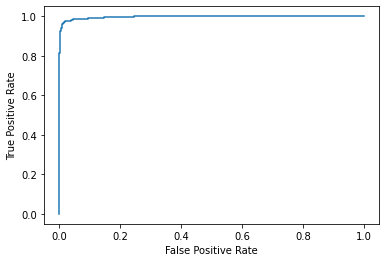

In [102]:
fpr_threshold = 0.01
fpr, tpr, thr = roc_curve(labels, predictions_proba)

index = np.argwhere(fpr <= fpr_threshold).flatten()[-1]
tpr_score = 100 * tpr[index]

optimal_threshold = thr[index]

RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
print(tpr_score, optimal_threshold)

In [103]:
predictions = predictions_proba.copy()
predictions[predictions_proba >= optimal_threshold] = 1
predictions[predictions_proba < optimal_threshold] = 0

print_metrics(predictions)

Confusion Matrix
-----------
[[2231   22]
 [  64 1523]]
Precision:	0.9857605177993527
Recall: 	0.9596723377441714
F1 Score:	0.9725415070242656
Roc Auc score:	0.9749537898219304


## Dev-clean

In [104]:
dev_clean_dataset = MaleFemaleDataset(
    audio_length=audio_file_length,
    transform=valid_audio_transforms,
    root=DATA_DIR, 
    url='dev-clean', 
    download=True
)
    
dev_clean_loader = data.DataLoader(
    dataset=dev_clean_dataset,
    batch_size=batch_size,
    shuffle=False,
    **kwargs
)

In [105]:
predictions_proba, labels = predict(model, dev_clean_loader)

prediction...: 100%|██████████| 37/37 [00:42<00:00,  1.14s/it]


81.39023317201935 0.5467209


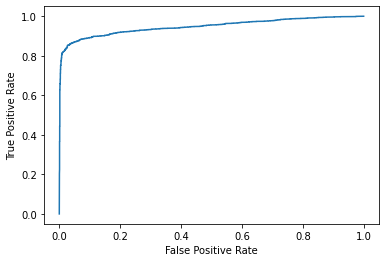

In [106]:
fpr_threshold = 0.01
fpr, tpr, thr = roc_curve(labels, predictions_proba)

index = np.argwhere(fpr <= fpr_threshold).flatten()[-1]
tpr_score = 100 * tpr[index]

optimal_threshold = thr[index]

RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
print(tpr_score, optimal_threshold)

In [107]:
predictions = predictions_proba.copy()
predictions[predictions_proba >= optimal_threshold] = 1
predictions[predictions_proba < optimal_threshold] = 0

print_metrics(predictions)

Confusion Matrix
-----------
[[2312   23]
 [ 423 1850]]
Precision:	0.987720234917245
Recall: 	0.8139023317201936
F1 Score:	0.8924264351181862
Roc Auc score:	0.9020261123269063


## Что еще можно попробовать?
1. Данные
    * Сейчас из каждого аудиофайла берется лишь первые несколько секунд в зависимости от параметра audio_length в MaleFemaleDataset. При этом в датасете есть достаточно большие аудиофайлы, где диктор произносит целые предложения. Можно из таких файлов нарезать еще данных размера audio_length. Это позволит увелить количество данных.
    * Попробовать разные варианты audio_length. Ожидается, что чем больше будет длина файла, тем большее сможем вытянуть свертками информации для итоговой классификации. Но не стоит забывать, что т.к. надо выравнивать аудио файлы, то при достаточно большом audio_length все меньшие файлы будет отбрасываться, что приведет к уменьшению датасета. 
    * Так же можно попробовать аугментации. Например, в pytorch уже есть реализованные FrequencyMasking и TimeMasking, которые случайным образом зануляют куски спектра по той или иной координате. 
    
2. Модель
    * **DONE.** МодельМодельМодельМодельМодельМодельВ данной работе я использовал достаточно простую модель и больше сконцентрировался на выстроении пайплайна и работе с данными. Но можно было рассмотреть модель с большим количеством слоев и residiual connections. Например, вот [тут](https://www.assemblyai.com/blog/end-to-end-speech-recognition-pytorch/) есть реализация похожей модели. 
3. Тренировка
    * Scheduler наше все.
    * Не забываем про правильно подобранный learning rate. 
    * Для наилучшей тренировки стоит добавить сохранение графиков в tensorboard, чтобы можно было наблюдать тренируется модель. 